In [1]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, adjusted_rand_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


2024-12-22 18:21:49.890368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734888109.909898   41743 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734888109.915284   41743 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-22 18:21:49.935636: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# Charger les datasets NSL-KDD
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
    "class", "difficulty"
]

train_data = pd.read_csv("Datasets/KDDTrain+.txt", header=None, names=columns)
test_data = pd.read_csv("Datasets/KDDTest+.txt", header=None, names=columns)



In [3]:
# Prétraitement des données
def preprocess_data(data):
    data = data.copy()

    # Encodage des colonnes catégoriques
    categorical_cols = ["protocol_type", "service", "flag"]
    for col in categorical_cols:
        encoder = LabelEncoder()
        data[col] = encoder.fit_transform(data[col])

    # Encodage de la classe cible
    data["class"] = data["class"].apply(lambda x: "benign" if x == "normal" else x)
    target_encoder = LabelEncoder()
    data["class"] = target_encoder.fit_transform(data["class"])

    return data

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Séparation des caractéristiques et des cibles
X_train = train_data.drop(columns=["class"])
y_train = train_data["class"]
X_test = test_data.drop(columns=["class"])
y_test = test_data["class"]

# Standardisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



Epoch 1/10


/home/brofessor/Documents/temp/M1-EFREI-Introduction-Machine-Learning/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-22 18:21:52.511934: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


3937/3937 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9479 - loss: 0.2665 - val_accuracy: 0.0161 - val_loss: 13.7130
Epoch 2/10
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9944 - loss: 0.0195 - val_accuracy: 0.0146 - val_loss: 16.4257
Epoch 3/10
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9955 - loss: 0.0139 - val_accuracy: 0.0067 - val_loss: 18.6430
Epoch 4/10
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9962 - loss: 0.0115 - val_accuracy: 0.0167 - val_loss: 21.4451
Epoch 5/10
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9970 - loss: 0.0097 - val_accuracy: 0.0208 - val_loss: 21.4514
Epoch 6/10
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9974 - loss: 0.0078 - val_accuracy: 0.0206 - val_loss: 25.7411
Epoch 7/10
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9977 - loss: 0.0081 - val_accuracy: 0.0150 - val_loss: 27.9113
Epoch 8/10
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9978 - loss: 0.0073 - val

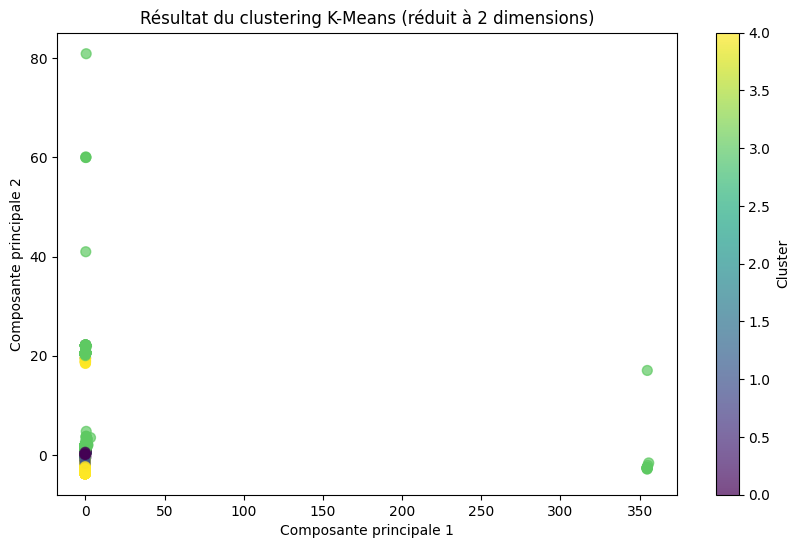

In [4]:
# Réseau de neurones supervisé
total_classes = max(np.max(y_train), np.max(y_test)) + 1

model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(total_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

# Entraînement
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Évaluation
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print("Accuracy sur les données de test :", accuracy)

# Méthode K-Means (clustering supervisé)
kmeans = KMeans(n_clusters=len(np.unique(y_train)), random_state=42)
kmeans.fit(X_train)
clusters = kmeans.predict(X_test)

# Comparaison des clusters avec les classes réelles
print("Score ARI :", adjusted_rand_score(y_test, clusters))

# Rapport de classification
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Rapport de classification :\n", classification_report(y_test, y_pred_classes, zero_division=0))

# Méthode K-Means pour 5 classes
kmeans_5 = KMeans(n_clusters=5, random_state=42)
kmeans_5.fit(X_train)
y_pred_5 = kmeans_5.predict(X_test)

# Comparaison avec les étiquettes initiales
score_5 = adjusted_rand_score(y_test, y_pred_5)
print(f"Score de clustering (Adjusted Rand Index) pour 5 classes : {score_5:.4f}")

# Visualisation des clusters (en 2D avec réduction de dimension)
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred_5, cmap='viridis', s=50, alpha=0.7)
plt.title('Résultat du clustering K-Means (réduit à 2 dimensions)')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.colorbar(label='Cluster')
plt.show()